
# Srujan Jabbireddy - Homework 3
Due 11:55pm on Wed 4th March

We study Table 13.2 on p240 of Lange and Chapter 13 Question 11 (p240) and Chapter 14 Example 14.10.1 (p264).

The table contains counts of the number of days that a given number of deaths occurred. The data are from The London Times in the years 1910-1912.

In [1]:
import numpy as np
import scipy.special
freq = np.array([162,267,271,185,111,61,27,8,3,1])

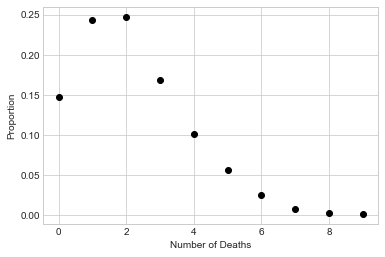

In [2]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

## proportion of different number of deaths
plt.plot(np.arange(freq.size), freq/np.sum(freq), 'o', color='black')
plt.xlabel("Number of Deaths")
plt.ylabel("Proportion")
plt.show()

# Problem 1
Confirm Lange's claim in question 11 that "A Poisson distribution gives a poor fit to these data . . ." by computing the MLE of the Poisson parameter  𝜆  (this should be done by hand using calculus) and plotting the resulting probability mass function over the observed data. They should be a bit discrepant (thus justifying the claim).

The Poisson probability mass function is$$ f(x|\lambda) = \frac{e^{-\lambda}\lambda^x}{x!}$$

The MLE maximizes the log likelihood. 

The log likelihood for the sample is $$ 
\begin{align*}
\log f(\vec{x}) &= \log \prod_{i=1}^n f(x_i|\lambda)\ \\
                & = \sum_{i=1}^n \log f(x_i|\lambda)\ \\
                & = \sum_{i=1}^n (-\lambda + x_i\log \lambda - \log x!)\ \\
                & = -n\lambda + \sum_{i=1}^n(x_i)  \log \lambda - \sum_{i=1}^n \log x! 
\end{align*} $$

Differentienting, setting equal to $0$, and solving for $\lambda$, we obtain$$ \widehat{\lambda} = \bar{X} = \frac{1}{n}\sum_{i=1}^n x_i $$In other words, the MLE is the sample mean.

We now compute the sample mean for this data.

In [3]:
np.arange(freq.size)*freq

array([  0, 267, 542, 555, 444, 305, 162,  56,  24,   9])

In [4]:
# mean number of deaths = total deaths / number of days
death_mle = np.sum(np.arange(freq.size)*freq)/(np.sum(freq))
death_mle

2.156934306569343

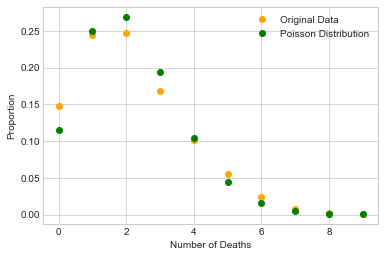

In [6]:
from scipy.stats import poisson
plt.style.use('seaborn-whitegrid')


## proportion of different number of deaths
plt.plot(np.arange(freq.size), freq/np.sum(freq), 'o', 
         color='orange',label = 'Original Data')
plt.plot(np.arange(freq.size), 
         poisson.pmf(np.arange(freq.size),death_mle),'o',
         color='green',label='Poisson Distribution')

plt.legend()
plt.xlabel("Number of Deaths")
plt.ylabel("Proportion");

# Problem 2
Fit the  𝛼 ,  𝜇1  and  𝜇2  parameters for the mixture of two Poissons model proposed in Question 11 using a gradient ascent algorithm. You must write your own fitting code (you cannot use scipy optimize or R optim). Discuss how you select starting parameters and monitor convergence. Include a plot to illustrate the convergence for different starting values of the parameters.

In problem 1 we used standard notation for the data i.e. $x_1$ was the number of deaths on day 1. <br>
Now we let $n_i =$ number of days with $i$ deaths. 
So$$n_i = \sum_j \mathbb{1}_{X_j=i}$$

The likelihood is$$f(\vec{n}|\alpha,\mu_1,\mu_2) = \prod_{i=0}^9 \left(\underbrace{\alpha e^{-\mu_1} \frac{\mu_1^i}{i!} + (1-\alpha)e^{-\mu_2}\frac{\mu_2^i}{i!}}_{\equiv g_i}\right)^{n_i}$$



So the log likelihood is$$ \log \, f = \sum_{i=0}^9 n_i \log(g_i) $$

The gradient is$$ \frac{\partial log f}{\partial \alpha} = \sum_{i=0}^9 \frac{n_i}{g_i} (e^{-\mu_1} \frac{\mu_1^i}{i!} - e^{-\mu_2}\frac{\mu_2^i} {i!})$$and $$ \frac{\partial log f}{\partial \mu_j} = \sum_{i=0}^9 \frac{n_i}{g_i} \frac{\partial g_i}{\partial \mu_j}$$ for $j=1,2$ and where$$ \frac{\partial log f}{\partial \mu_1} = -\frac{n_0}{g_0} (\alpha e^{-\mu_1}) + \sum_{i=1}^9 \frac{n_i}{g_i} \frac{\alpha e^{-\mu_1} (i- \mu_1) \mu_1^{i-1}}{i!}$$$$ \frac{\partial log f}{\partial \mu_2} = -\frac{n_0}{g_0} ((1-\alpha) e^{-\mu_2}) + \sum_{i=1}^9 \frac{n_i}{g_i} \frac{(1-\alpha) e^{-\mu_2} (i- \mu_2) \mu_2^{i-1}}{i!}$$



<br>Note the indicator functions. These are important for the second terms in the $\partial g_i / \partial \mu_j$ which are $0$ for $i=0$ (because we are differentiating a constant).

In [7]:
#defining g function
def g(alpha,mu1,mu2,i):
    i_fact = scipy.special.factorial(i)
    return (alpha*np.exp(-mu1)*np.power(mu1,i)/i_fact) + ((1-alpha)*np.exp(-mu2)*np.power(mu2,i)/i_fact)

Definig LOG-LIKELIHOOD function

In [8]:
def log_likelihood(params,n):
    like=g(params[0],params[1],params[2],n.size)
    if np.min(like) < 0:
        return -np.inf 
    else:
        z =0
        for i in range(0,10):
            p = n[i]*np.log(g(params[0],params[1],params[2],i))
            z = z+p
        return z 

Calculating Loglikehoood - Gradient Ascent derivates

Alpha-gradient log

In [9]:
def lograd_alpha(params,n):
    alpha = params[0]
    mu1 = params[1]
    mu2 = params[2]
    z = 0
    for i in range(0,10):
        i_fact = scipy.special.factorial(i)
        p = (n[i]/(g(alpha,mu1,mu2,i)*i_fact))*((np.exp(-mu1)*np.power(mu1,i)) - (np.exp(-mu2)*np.power(mu2,i)))
        z = z+p
    return z


Defining MU gradients

In [10]:

#mu1 gradient
def lograd_mu1(params,n):
    alpha = params[0]
    mu1 = params[1]
    mu2 = params[2]
    
    z = 0
    const = -n[0]*alpha*np.exp(-mu1)/(g(alpha,mu1,mu2,0))
    for i in range(1,10):
        i_fact = scipy.special.factorial(i)
        p = (n[i]/g(alpha,mu1,mu2,i))*(alpha/i_fact)*(np.exp(-mu1)*np.power(mu1,i-1)*(i-mu1))
        z=z+p
    return (z+const)


In [11]:
#mu2 gradient
def lograd_mu2(params,n):
    alpha = params[0]
    mu1 = params[1]
    mu2 = params[2]
    z = 0
    const = -n[0]*(1-alpha)*np.exp(-mu2)/(g(alpha,mu1,mu2,0))
    for i in range(1,10):
        i_fact = scipy.special.factorial(i)
        p = (n[i]/g(alpha,mu1,mu2,i))*((1-alpha)/i_fact)*(np.exp(-mu2)*np.power(mu2,i-1)*(i-mu2))
        z=z+p
    return (z+const)  


Functioning the gradient derivates

In [21]:
def gradient_ascent(param_initial):
    #running for 1000 iterations for the algorithm to converge
    #(as we dont know where will it converge)
    Niter = 1000
    #creating matrix of no. of iterations size
    param = np.zeros((Niter+1)*3).reshape(Niter+1,3)
    param[0,:] = param_initial

    for ii in np.arange(Niter):
        lgrad_alpha = lograd_alpha(param[ii,:],freq)
        lgrad_mu1 = lograd_mu1(param[ii,:],freq)
        lgrad_mu2 = lograd_mu2(param[ii,:],freq)
        lgrad = np.array((lgrad_alpha, lgrad_mu1, lgrad_mu2))
        half = True 
         ## step half until new point increases likelihood    
        while half:
            param_temp = param[ii,:] + lgrad
            newlik = log_likelihood(param_temp,freq)
            ## for temp far from maximum, logit_loglik returns
            ## Nan values. we replace these with -Inf log likelihoods
            if np.isnan(newlik): 
                newlik = -np.inf
            if (newlik < log_likelihood(param[ii,:],freq)):
                lgrad = lgrad / 2
            else:
                half = False
        param[ii+1,:] = param_temp
    return param


We choose starting values of parameter as follows(taken from textbook):
Since in 1st question when we use single poisson distribution we get mean value of 2.156. 
Therefore, for the mixture of poisson distribution one value should be below and one value should be above this value. 
Hence here we use mu1=1 and mu2=2.5 
For alpha, we choose initial value of 0.3 since we believe that the contribution of parameter with high mean will be more as
observed from the graph in the 1st question.

In [23]:
param_initial_1 = np.array((0.3,1.0,2.5))
param1 = gradient_ascent(param_initial_1)
param1[1000,:]

C:\Users\jsruj\Anaconda3\envs\Stat 654\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  


array([0.35988489, 1.25609417, 2.66340372])

Taking other alpha, mu1,mu2 values and checking the converges 

In [24]:
param_initial_2 = np.array((0.5,0.5,4.1))
param2 = gradient_ascent(param_initial_2)
param2[1000,:]

C:\Users\jsruj\Anaconda3\envs\Stat 654\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  


array([0.35988588, 1.25609595, 2.66340494])

In [25]:
param_initial_3 = np.array((0.8,0.1,1.0))
param3 = gradient_ascent(param_initial_3)
param3[1000,:]

C:\Users\jsruj\Anaconda3\envs\Stat 654\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
C:\Users\jsruj\Anaconda3\envs\Stat 654\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  


array([0.35988518, 1.25609471, 2.66340409])

Plot Parameter Paths

Plotting the $\mu_1$, $\mu_2$ parameter paths. We could also plot these paths for $\alpha$.

In [26]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np

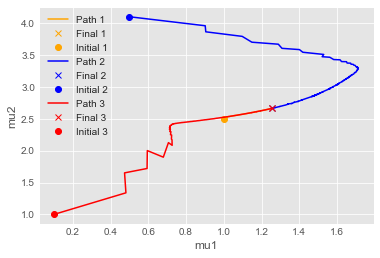

In [27]:
## sequence 1
n1 = len(param1)-1
plt.plot(param1[:,1],param1[:,2],color='orange',label="Path 1")
plt.plot(param1[n1,1],param1[n1,2],'x',color='orange',label="Final 1")
plt.plot(param1[0,1],param1[0,2],'o',color='orange',label="Initial 1")
## sequence 2
n2 = len(param2)-1
plt.plot(param2[:,1],param2[:,2],color='blue',label="Path 2")
plt.plot(param2[n2,1],param2[n2,2],'x',color='blue',label="Final 2")
plt.plot(param2[0,1],param2[0,2],'o',color='blue',label="Initial 2")
## sequence 3
n3 = len(param3)-1
plt.plot(param3[:,1],param3[:,2],color='red',label="Path 3")
plt.plot(param3[n3,1],param3[n3,2],'x',color='red',label="Final 3")
plt.plot(param3[0,1],param3[0,2],'o',color='red',label="Initial 3")
plt.xlabel("mu1")
plt.ylabel("mu2")
leg = plt.legend(loc='upper left')
plt.show()

We can see the starting points and their gradient helping to converge to one point

# Problem 3
Confirm your answer to Question 2 using the built in Python or R optimizers. Also provide a confidence interval for each of the three parameters.

In [28]:
#First we redefine the log likelihood function that takes one parameter and the function calculates negative
#log likelihood so that we minimize the function using optim

def loglikehood_optim(param):
    alpha = param[0]
    mu1 = param[1]
    mu2 = param[2]
    z = 0
    for i in range(10):
        i_fact = scipy.special.factorial(i)
        p = freq[i]*(np.log(alpha*np.exp(-mu1)*np.power(mu1,i)/i_fact + (1-alpha)*np.exp(-mu2)*np.power(mu2,i)/i_fact))
        z=z+p
    return -z

In [29]:
def gradient_ascent_fn(param):
    lgrad_alpha= -lograd_alpha(param,freq)
    lgrad_mu1 = -lograd_mu1(param,freq)
    lgrad_mu2 = -lograd_mu2(param,freq)
    return np.array((lgrad_alpha, lgrad_mu1, lgrad_mu2))

In [30]:
#Now we input the initial value of parameters and the function that needs to be minimized in the 'optim' function
param_initial = np.array((0.3,1.0,2.5))
param = param_initial

result = scipy.optimize.fmin(loglikehood_optim, param)
result

Optimization terminated successfully.
         Current function value: 1989.945860
         Iterations: 67
         Function evaluations: 121


array([0.3598576 , 1.25603686, 2.66337702])

In [31]:
#Using different in-built methods for optimization

result = scipy.optimize.minimize(loglikehood_optim, param, method='BFGS',jac=gradient_ascent_fn)
result


C:\Users\jsruj\Anaconda3\envs\Stat 654\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()


      fun: 1989.9458598829642
 hess_inv: array([[0.03778023, 0.06489559, 0.04602783],
       [0.06489559, 0.12237734, 0.0755518 ],
       [0.04602783, 0.0755518 , 0.06233602]])
      jac: array([-9.78002144e-07,  4.75599606e-07,  1.69638014e-07])
  message: 'Optimization terminated successfully.'
     nfev: 17
      nit: 13
     njev: 17
   status: 0
  success: True
        x: array([0.3598854 , 1.25609511, 2.66340436])

* Now to get the confidence intervals, we need to calculate the standard error. 
* Standard error is obtained by taking the square root of the diagonal elements of inverse of hessian matrix
* The standard error is then multiplied by 1.96 to obtain the 95% confidence interval

Calculating confidence intervals

In [32]:
sigma= np.sqrt(np.diagonal(result.hess_inv))
upper = result.x+1.96*sigma
lower = result.x-1.96*sigma
import pandas as pd
confidence_interval = pd.DataFrame({'minimized': result.x,
                    'upper': upper,
                    'lower': lower})
confidence_interval.index=['alpha','mu1','mu2']
confidence_interval

,minimized,upper,lower
alpha,0.359885,0.740853,-0.021082
mu1,1.256095,1.941752,0.570439
mu2,2.663404,3.152761,2.174048


In [55]:
confidence_interval = pd.DataFrame({'inbuilt_minimized': result.x, 'manual_minimized' : param1[1000,:],
                    'upper': upper,
                    'lower': lower})
confidence_interval.index=['$\alpha$', '$\mu_1$' , '$\mu_2$']
confidence_interval

,inbuilt_minimized,manual_minimized,upper,lower
$lpha$,0.359885,0.359885,0.740853,-0.021082
$\mu_1$,1.256095,1.256094,1.941752,0.570439
$\mu_2$,2.663404,2.663404,3.152761,2.174048


# Problem 4
Implement the EM algorithm approach detailed in Question 11 to fit the parameter  𝛼 ,  𝜇1  and  𝜇2 .

Compare the number of steps and the computation time of the EM algorithm to the gradient ascent method you used in Problem 2.
State which is faster and why you think this is the case.
Lastly, name one advantage of each method.

In [57]:
# Values given in the textbook
alpha = 0.3
mu1 = 1
mu2 = 2.5

In [35]:
def Ez(alpha,mu1,mu2,k):
    term1 = alpha*np.exp(-mu1)*np.power(mu1,k)
    term2 = (1-alpha)*np.exp(-mu2)*np.power(mu2,k)
    return term1/(term1+term2)

In [36]:
# Check function
Ez_vec = np.array(list(map(lambda y: Ez(alpha,mu1,mu2,y), np.arange(10))))
Ez_vec

array([6.57619125e-01, 4.34481758e-01, 2.35073895e-01, 1.09469629e-01,
       4.68661004e-02, 1.92888357e-02, 7.80587401e-03, 3.13704202e-03,
       1.25718311e-03, 5.03252852e-04])

In [39]:
# Run EM algorithm
def em_poisson_alg(alpha,mu1,mu2,X,para,liketol):
    old_likelihood = -np.inf
    likelihood_diff = np.inf
    iter_count = 0
    para_diff = np.inf

    while para_diff > para or likelihood_diff > liketol:
        mu11 = mu1
        mu22 = mu2
        alpha_a = alpha
        Ez_vec = np.array(list(map(lambda y: Ez(alpha,mu1,mu2,y), np.arange(10))))
        alpha = sum(X*Ez_vec)/sum(X)
        mu1 = sum(X*np.arange(10)*Ez_vec)/sum(X*Ez_vec)
        mu2 = sum(X*np.arange(10)*(1-Ez_vec))/sum(X*(1-Ez_vec))
        # Check convergence
        para_diff = sum(np.absolute([alpha-alpha_a,mu1-mu11,mu2-mu22]))
        new_likelihood = log_likelihood([alpha,mu1,mu2],X)
        likelihood_diff = np.absolute(new_likelihood-old_likelihood)
        old_likelihood = new_likelihood
        iter_count = iter_count + 1
    return [alpha,mu1,mu2,iter_count,para_diff,likelihood_diff]

In [40]:
em_out = em_poisson_alg(alpha,mu1,mu2,freq,10e-6,10e-6)

In [41]:
em_out[0:3]

[0.3593075138402641, 1.255089824982245, 2.662698781023993]

The $\alpha$, $\mu_1$ and $\mu_2$ values are 0.3593, 1.2550 and 2.6626 respectively which are very close to the actual value

In [42]:
em_out

[0.3593075138402641,
 1.255089824982245,
 2.662698781023993,
 1116,
 9.968900464174535e-06,
 3.8574398786295205e-08]

In [43]:
##Calculating time

In [45]:
%timeit em_out = em_poisson_alg(alpha,mu1,mu2,freq,10e-6,np.inf) # No likelihood tolerance

1.02 s ± 110 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [46]:
param_initial_1 = np.array((0.3,1.0,2.5))
%timeit param1 = gradient_ascent(param_initial_1)

C:\Users\jsruj\Anaconda3\envs\Stat 654\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  


26.3 s ± 3.41 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [48]:
em_steps = np.zeros(100)
for ii in np.arange(100):
    alpha = np.random.uniform(0,1,1)[0]
    mu1 = np.random.uniform(0,5,1)[0]
    mu2 = np.random.uniform(0,5,1)[0]
    em_steps[ii] = em_poisson_alg(alpha,mu1,mu2,freq,10e-6,np.inf)[3]

The EM algorithm seems to be a bit faster here. However this could be due to the implementation because it takes nearly 3 times as many iterations to converge (though we should not forget that the gradient ascent algorithm may do one or more halvings within each step).

Checking if the mixture model is a good fit:

In [49]:
deaths = np.arange(10)
freq = np.array([162, 267, 271, 185, 111, 61, 27, 8, 3, 1])
i, ni = deaths, freq
i_fac = scipy.special.factorial(i)
alpha0, mu10, mu20 = [0.35987258442400516, 1.2560722507101618, 2.6633886707631791]
pois_mle = (alpha0*np.exp(-mu10)*mu10**i+(1-alpha0)*np.exp(-mu20)*mu20**i)/i_fac
print(f'{np.sum(pois_mle):.4}')

0.9997


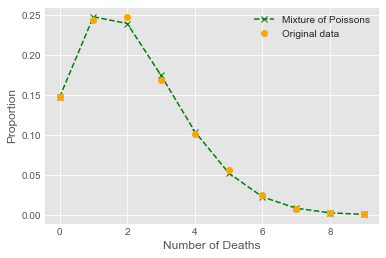

In [51]:

plt.plot(i, pois_mle,'x--', color='green',label='Mixture of Poissons')
plt.plot(np.arange(freq.size), freq/np.sum(freq), 'o', color='orange',label='Original data')
plt.legend()
plt.xlabel("Number of Deaths")
plt.ylabel("Proportion");


***Comparison of methods:<br>***

***The gradient ascent optimization method has 5 steps: <br>***
1. First calculate log likelihood
2. Calculate gradient for all the 3 parameters. 
3. Then update the parameters and check condition if new likelihood is greater than the previous one. 
3a. We also will be checking for Nan values since gradient may be negative.<br>
4. The EM algorithm involves calculating Ez, $\alpha$ $\mu1$ and $\mu2$ and updating the value with each iteration until the increase in likelihood is less than a particular threshold.<br>

Hence we can see that the EM algorithm requires less steps as compared to the gradient ascent method.<br>

* Also, we see that the running time of poisson gradient is more than that of EM method. 
* (Here we observe a huge difference because we are running the posisson algorithm for 1000 times.Even without 1000 iterations that it runtime is more than EM Algorithm).
* The gradient ascent method is slower since it involves computing the gradient at each iteration which is computationally expensive. <br>

***Advantages of each method:***

1. Loglikehood function has a close form solution and hence can converge faster than EM Method.
    * This comes with caveat of choosing good starting values
2. The EM method is more stable and tends to converge even if the starting values are off target.